### Escreva aqui seu nome: Diego Alysson Braga Moreira

# PyTorch: Gradientes e Grafo Computacional

## Objetivos

Este notebook introduz 
- o conceito de autograd do PyTorch,
- uma interpretação numérica intuitiva do gradiente, e o
- grafo computacional, utilizado para o cálculo automático do gradiente de uma função.

Um dos principais fundamentos para que o PyTorch seja adequado para deep learning é a sua habilidade de
calcular o gradiente automaticamente a partir da expressões definidas. Essa facilidade é implementada
pelo tensor através do cálculo automático do gradiente pela construção dinâmica do grafo computacional.

## Grafo computacional

```
    y_pred = x * w
    e = y_pred - y
    e2 = e**2
    J = e2.sum()
```

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/GrafoComputacional.png" width="600pt"/>

Para conhecer com maior profundidade a diferenciação automática usando grafo computacional, veja esta nota de aula:
https://cs231n.github.io/optimization-2/

In [ ]:
import torch
import random

In [ ]:
torch.__version__

'1.8.1+cu101'

## Se um tensor possui .requires_grad=True

In [ ]:
y = 2 * torch.arange(0,4).float()
y

tensor([0., 2., 4., 6.])

In [ ]:
x = torch.arange(0,4).float(); x

tensor([0., 1., 2., 3.])

In [ ]:
w = torch.ones(1,requires_grad=True); w

tensor([1.], requires_grad=True)

## Cálculo automático do gradiente da função perda J

Seja a expressão: $$ J = \sum ((x  w) - y)^2 $$

Queremos calcular a derivada de $J$ em relação a $w$.

### Montagem do grafo computacional

In [ ]:
# predict (forward)
y_pred = x * w

# cálculo da perda J: loss
e = y_pred - y
e2 = e.pow(2)
J = e2.sum()
J

tensor(14., grad_fn=<SumBackward0>)

## Auto grad - processa o grafo computacional backwards

O `backward()` varre o grafo computacional a partir da variável a ele associada e calcula o gradiente para todos os tensores que possuem o atributo `requires_grad` como verdadeiro.
O `backward()` destroi o grafo após sua execução. Isso é intrínsico ao PyTorch pelo fato dele ser uma rede dinâmica.

In [ ]:
J.backward()
print(w.grad)

tensor([-28.])


In [ ]:
# w.grad.data.zero_();

## Interpretação do Gradiente

O gradiente de uma variável final (J) com respeito à outra variável de entrada (w) pode ser interpretado como o quanto a variável final J vai aumentar se houver um pequeno aumento na variável de entrada (w).
Por exemplo suponha que o gradiente seja 28. Isto significa se aumentarmos a variável w de 0.001, então J vai aumentar de 0.028.

In [ ]:
eps = 0.001
y_pred = x * (w + eps)
J_new = (y_pred - y).pow(2).sum()
J_new

tensor(13.9720, grad_fn=<SumBackward0>)

In [ ]:
print(J_new - J)

tensor(-0.0280, grad_fn=<SubBackward0>)


## Backpropagation

Uma forma equivalente explícita de calcular o gradiente é fazendo o processamento do backpropagation no grafo computacional, de forma explícita.
Apenas como ilustração.

In [ ]:
import numpy as np

dJ = 1.
de2 = dJ * np.ones((4,))
de = de2 * 2 * e.data.numpy()
dy_pred = de
dw = (dy_pred * x.data.numpy()).sum()
print(dJ)
print(de2)
print(de)
print(dw)

1.0
[1. 1. 1. 1.]
[ 0. -2. -4. -6.]
-28.0


## Visualizando o grafo computacional

In [ ]:
!pip install torchviz

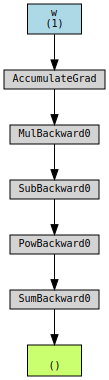

In [ ]:
import torchviz
J = ((w * x) - y).pow(2).sum()
p = {'w':w} # dicionário de parâmetros
out = torchviz.make_dot(J,params=p)
out

Iremos agora visualizar a Resnet, que é uma rede neural bastante popular em visão computacional.

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


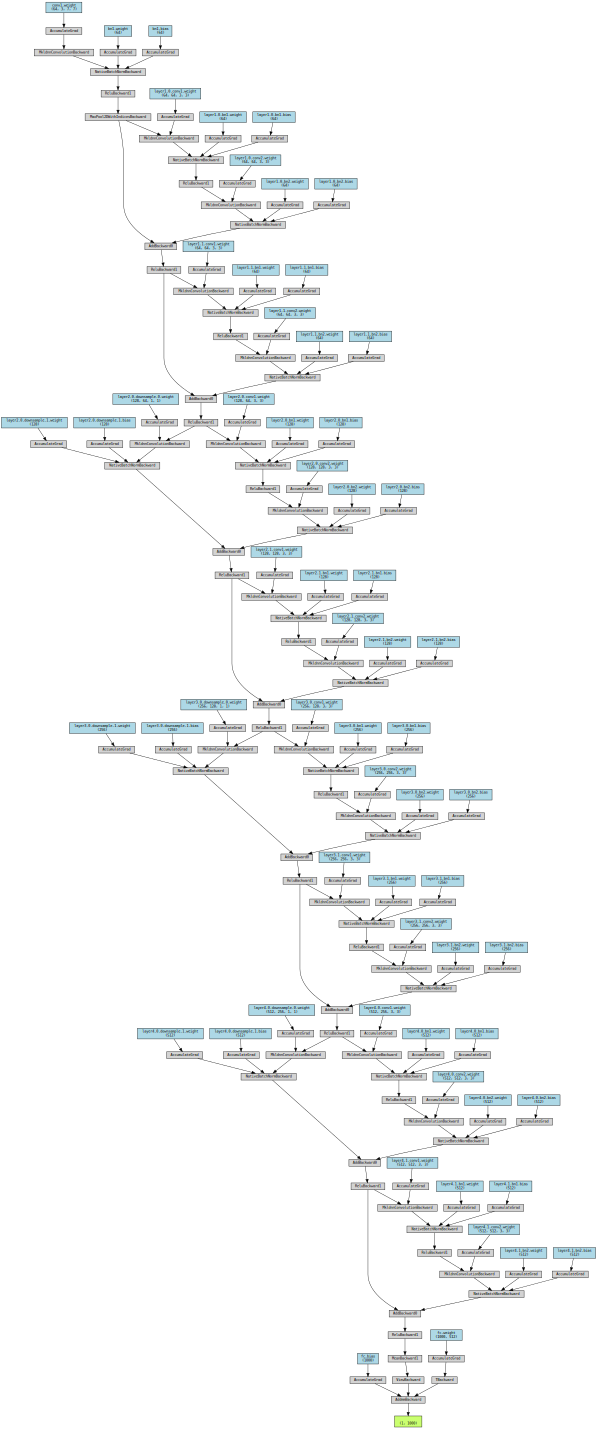

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
x_res = torch.randn(1,3,224,224)  # First, create a random image.
y_res = model(x_res)  # We need one forward pass so the graph can be build.
out = torchviz.make_dot(y_res, params=dict(model.named_parameters()))  # Create a figure from the computaional graph..
torchviz.dot.resize_graph(out, size_per_element=0.05)  # Resize to fit on the screen.
out

# Exercício 1

O que acontece com o grafo computacional após execução do `backward()`?

Resposta: Após varrer todo o grafo computacional e recalcular os valores dos gradientes, das variáveis com atriburo requires_grad, o pytorch destroi o grafo, liberando memória.

# Exercício 2

Execute um passo de atualização do valor de w, pelo 
gradiente descendente. Utilize um fator de aprendizado (*learning rate*) de 0.1 
para atualizar o `w`. Após, recalcule a função de perda:

    - w = w - lr * w.grad.data
    - execute a célula 1.3.1 e verifique o quanto que a perda J diminuiu

In [ ]:
# Escreva seu código aqui:
lr = 0.01
wnew = w - lr * w.grad.data
print(w,w.grad.data)

ypred = x * wnew
Jnew = (ypred - y).pow(2).sum()
print('J inicial: {} || J intermediario {} || J final: {} || J-J intermeridário: {} || J inicial - J final: {} '.format( J, J_new, Jnew, J-J_new, J-Jnew))

tensor([1.], requires_grad=True) tensor([-28.])
J inicial: 14.0 || J intermediario 13.97201156616211 || J final: 7.2576003074646 || J-J intermeridário: 0.027988433837890625 || J inicial - J final6.7423996925354: 


## Treinando uma rede no Pytorch

Para ajudar na entendimento dos exercícios abaixo, apresentamos o código em Pytorch para treinar uma rede de uma camada não-linear, com pesos `w` e `b`:
$y' = \sigma(wx + b)$

<img src="https://github.com/robertoalotufo/files/blob/master/figures/simple_graph.png?raw=true" width="600pt"/>

In [ ]:
import torch


class Net(torch.nn.Module):
  def __init__(self, dim):
    super(Net, self).__init__()

    self.layer1 = torch.nn.Linear(dim, 1) 
      
  def forward(self, x):
    y_pred = torch.sigmoid(self.layer1(x))
    return y_pred

learning_rate = 0.1
model = Net(dim=1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
x = torch.tensor([-5], dtype=torch.float)
y_target = torch.tensor([0.76], dtype=torch.float)
num_iterations = 50
for i in range(num_iterations):
  # Zera os gradientes dos passo anterior.
  optimizer.zero_grad()
  # Roda a um passo forward do modelo.
  y_pred = model.forward(x)
  # Calcula a loss
  loss = loss_fn(y_pred, y_target)
  # Calcula os gradientes
  loss.backward()
  # Atualiza os pesos
  optimizer.step()

  print(f'iter:{i}: y_prime: {y_pred}')

iter:0: y_prime: tensor([0.6680], grad_fn=<SigmoidBackward>)
iter:1: y_prime: tensor([0.6911], grad_fn=<SigmoidBackward>)
iter:2: y_prime: tensor([0.7072], grad_fn=<SigmoidBackward>)
iter:3: y_prime: tensor([0.7188], grad_fn=<SigmoidBackward>)
iter:4: y_prime: tensor([0.7275], grad_fn=<SigmoidBackward>)
iter:5: y_prime: tensor([0.7341], grad_fn=<SigmoidBackward>)
iter:6: y_prime: tensor([0.7392], grad_fn=<SigmoidBackward>)
iter:7: y_prime: tensor([0.7432], grad_fn=<SigmoidBackward>)
iter:8: y_prime: tensor([0.7464], grad_fn=<SigmoidBackward>)
iter:9: y_prime: tensor([0.7489], grad_fn=<SigmoidBackward>)
iter:10: y_prime: tensor([0.7509], grad_fn=<SigmoidBackward>)
iter:11: y_prime: tensor([0.7526], grad_fn=<SigmoidBackward>)
iter:12: y_prime: tensor([0.7539], grad_fn=<SigmoidBackward>)
iter:13: y_prime: tensor([0.7550], grad_fn=<SigmoidBackward>)
iter:14: y_prime: tensor([0.7559], grad_fn=<SigmoidBackward>)
iter:15: y_prime: tensor([0.7566], grad_fn=<SigmoidBackward>)
iter:16: y_prime: 

# Exercício 3

Vamos agora escrever nosso próprio código para calcular os gradientes da rede apresentada acima.

Para tanto, temos que primeiro implementar as funções `forward` e `backward` de cada um dos nós do grafo acima.
Vamos começar pelo nó da função sigmoid ($\sigma$), cuja derivada é:

$\frac{\delta\sigma}{\delta x} = \sigma(x)(1-\sigma(x))$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)


class SigmoidLayer():

  def forward(self, x):
    self.sigfor = 1/(1+np.exp(-x))
    return self.sigfor

  def backward(self, upstream_grad):
    return upstream_grad * self.sigfor * (1- self.sigfor)

Implementamos agora o `forward` e `backward` do nó da soma $z = x + y$, cujas derivadas parciais em relação a cada entrada $x$ e $y$ são:

$\frac{\delta z}{\delta x} = 1$

$\frac{\delta z}{\delta y} = 1$

In [ ]:
class SumLayer():

  def forward(self, x, y):
    z = x + y
    return z
  
  def backward(self, upstream_grad):
    return upstream_grad,upstream_grad

Implementamos agora o `forward` e `backward` do nó da multiplicação $z = xy$, cujas derivadas parciais em relação a cada entrada $x$ e $y$ são:

$\frac{\delta z}{\delta x} = y$

$\frac{\delta z}{\delta y} = x$

In [ ]:
class MulLayer():

  def forward(self, x, y):
    model.mulStack.append([x,y])
    z = x * y
    return z
  
  def backward(self, upstream_grad):
    x,y = model.mulStack.pop()
    return y*upstream_grad, x*upstream_grad

Agora que temos todos os nós implementados, podemos implementar as funções `forward` e `backward` do grafo computacional, ou seja, da rede neural como um todo.

In [ ]:
class Net():

  def __init__(self, dim):
    # Escreva o código aqui:
    self.w = random.random()
    self.b = random.random()
    self.Mul = MulLayer()
    self.Sum = SumLayer()
    self.Sig = SigmoidLayer()
    self.mulStack = []

  def forward(self, x):
    # Escreva o código aqui:
    dot = self.Mul.forward(x,self.w)
    sum = self.Sum.forward(dot, self.b)
    sig = self.Sig.forward(sum)
    return sig

  def backward(self, upstream_grad):
    # Escreva o código aqui:
    dsig = self.Sig.backward(upstream_grad)
    dsum, db = self.Sum.backward(dsig)
    dx, dw = self.Mul.backward(dsum)
    return dw,db

Para treinar esta rede, usaremos a função de custo Mean Squared Error (MSE):

$L = (y_\text{pred} - y_\text{target})^2$ 

Para tanto, precisamos construir uma função que calcular o gradiente desse custo:

In [ ]:
def compute_grad_loss(y_target, y_pred):
  # Escreva o código aqui:
  # loss = (y_pred - y_target) ** 2
  # derivada da loss em relação y_pred
  return 2*(y_pred - y_target)

Por fim, vamos aprender os pesos `w` e `b` para mapear um valor de entrada $x$ para um valor de saída $y_\text{target}$. Para isso, inicializamos o grafo da rede e rodamos o laço de optimização, que vai aplicar a descida do gradiente a cada iteração:

iter:0: y_prime: 0.18768497337863857
iter:1: y_prime: 0.26670623528156157
iter:2: y_prime: 0.37525769608537307
iter:3: y_prime: 0.4898281958780885
iter:4: y_prime: 0.5769792706483311
iter:5: y_prime: 0.6324338823298052
iter:6: y_prime: 0.6674943802354334
iter:7: y_prime: 0.690751835420828
iter:8: y_prime: 0.7069375930934023
iter:9: y_prime: 0.718639278413193
iter:10: y_prime: 0.7273481660496112
iter:11: y_prime: 0.7339742940793942
iter:12: y_prime: 0.7391018783633078
iter:13: y_prime: 0.7431223292627818
iter:14: y_prime: 0.746307360727706
iter:15: y_prime: 0.7488512340788992
iter:16: y_prime: 0.7508962762807371
iter:17: y_prime: 0.7525489082104868
iter:18: y_prime: 0.7538900631074287
iter:19: y_prime: 0.7549821662168292
iter:20: y_prime: 0.7558739372858058
iter:21: y_prime: 0.756603774325397
iter:22: y_prime: 0.7572021885442785
iter:23: y_prime: 0.7576935896371315
iter:24: y_prime: 0.7580976166722507
iter:25: y_prime: 0.758430144897731
iter:26: y_prime: 0.7587040572728218
iter:27: y_pr

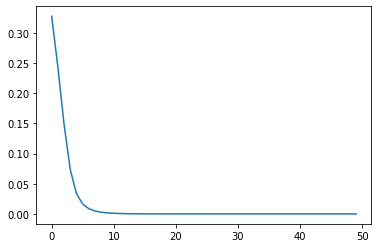

In [ ]:
model = Net(dim=1)
learning_rate = 0.1
x = -5
y_target = 0.76
num_iterations = 50
losses = []
for i in range(num_iterations):
  # Rode a um passo forward do modelo.
  y_pred = model.forward(x)
  #Calculo da loss para gráfico
  loss = (y_pred - y_target) ** 2
  losses.append(loss)
  # Calcule o gradiente do erro, data a predição do modelo.
  loss_grad = compute_grad_loss(y_target=y_target, y_pred=y_pred)
  # Calcule agora os gradientes de w e b usando a função backward do modelo.
  w_grad, b_grad = model.backward(loss_grad)
  # Atualize os pesos w e b usando os seus respectivos gradientes.
  # Escreva o código aqui:
  model.w = model.w - learning_rate*w_grad
  model.b = model.b - learning_rate*b_grad
  
  print(f'iter:{i}: y_prime: {y_pred}')

plt.plot(losses)

# Exercício 4

Repita o exercício 3 mas usando uma rede com duas camadas não-lineares:

$a = \sigma(w_1x + b_1)$

$y' = \sigma(w_2a + b_2)$

iter:0: y_prime: 0.6557168762654572
iter:1: y_prime: 0.6668267123216713
iter:2: y_prime: 0.6764890786465412
iter:3: y_prime: 0.6849339017232028
iter:4: y_prime: 0.6923490626128382
iter:5: y_prime: 0.6988884934326212
iter:6: y_prime: 0.7046788611491748
iter:7: y_prime: 0.7098249490987671
iter:8: y_prime: 0.7144139373908646
iter:9: y_prime: 0.7185187905472961
iter:10: y_prime: 0.722200936704026
iter:11: y_prime: 0.7255123905923423
iter:12: y_prime: 0.7284974417161751
iter:13: y_prime: 0.7311940028369182
iter:14: y_prime: 0.7336346926015421
iter:15: y_prime: 0.7358477094233896
iter:16: y_prime: 0.737857540771656
iter:17: y_prime: 0.7396855420693501
iter:18: y_prime: 0.7413504117697205
iter:19: y_prime: 0.7428685833347713
iter:20: y_prime: 0.744254550351852
iter:21: y_prime: 0.7455211375694201
iter:22: y_prime: 0.7466797279632992
iter:23: y_prime: 0.7477404538728791
iter:24: y_prime: 0.7487123586314898
iter:25: y_prime: 0.7496035338499955
iter:26: y_prime: 0.7504212365168724
iter:27: y_pri

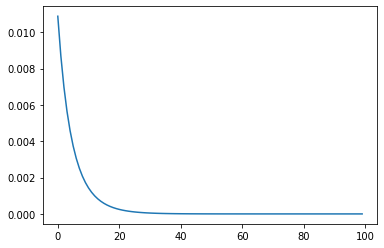

In [ ]:
import numpy as np
np.random.seed(1)


class Net():

  def __init__(self, dim=1):
    self.w1 = random.random()
    self.w2 = random.random()
    self.b1 = random.random()
    self.b2 = random.random()
    self.Mul = MulLayer()
    self.Sum = SumLayer()
    self.Sig = SigmoidLayer()
    self.mulStack = []

  def forward(self, x):
    # Escreva o código aqui:
    #foward em a
    dot = self.Mul.forward(x,self.w1)
    sum = self.Sum.forward(dot,self.b1)
    a = self.Sig.forward(sum)
    #foward em y
    dot = self.Mul.forward(a,self.w2)
    sum = self.Sum.forward(dot,self.b2)
    y = self.Sig.forward(sum)
    return y
  
  def backward(self, upstream_grad):
    # Escreva o código aqui:
    #backward em y
    dsig = self.Sig.backward(upstream_grad)
    dsum, db2 = self.Sum.backward(dsig)
    da, dw2 = self.Mul.backward(dsum)
    #backward em a
    dsig = self.Sig.backward(da)
    dsum, db1 = self.Sum.backward(dsig)
    dx, dw1 = self.Mul.backward(dsum)

    return dw1, db1, dw2, db2

model = Net(dim=1)
learning_rate = 1.0
x = -5
y_target = 0.76
losses = []
for i in range(100):
  y_pred = model.forward(x)
  #Calculo da loss para gráfico
  loss = (y_pred - y_target) ** 2
  losses.append(loss)
  loss_grad = compute_grad_loss(y_target=y_target, y_pred=y_pred)
  w1_grad, b1_grad, w2_grad, b2_grad = model.backward(loss_grad)
  # Escreva o código aqui para atualizar os pesos:
  model.w1 = model.w1 - learning_rate * w1_grad
  model.w2 = model.w2 - learning_rate * w2_grad
  model.b1 = model.b1 - learning_rate * b1_grad
  model.b2 = model.b2 - learning_rate * b2_grad

  print(f'iter:{i}: y_prime: {y_pred}')

plt.plot(losses)

# Exercício 5

Repita o exercício 4 mas compartilhando os pesos das duas camadas. Mostre que ambas tem os mesmos pesos após o treino.

iter:0: y_prime: 0.6938216949202131
model.w1: 0.7304679163609579
model.w2: 0.1338801980149678
iter:1: y_prime: 0.699917808088489
model.w1: 0.7284942109351366
model.w2: 0.13190649258914644
iter:2: y_prime: 0.7053264565243237
model.w1: 0.7268074152239976
model.w2: 0.1302196968780075
iter:3: y_prime: 0.710145006138301
model.w1: 0.7253550095226782
model.w2: 0.12876729117668811
iter:4: y_prime: 0.7144539683275921
model.w1: 0.7240960121554949
model.w2: 0.1275082938095049
iter:5: y_prime: 0.7183203908876181
model.w1: 0.7229980649722416
model.w2: 0.1264103466262516
iter:6: y_prime: 0.7218004913600413
model.w1: 0.7220353403239149
model.w2: 0.1254476219779249
iter:7: y_prime: 0.7249417139227389
model.w1: 0.7211870165045109
model.w2: 0.12459929815852089
iter:8: y_prime: 0.7277843462502464
model.w1: 0.720436152494721
model.w2: 0.12384843414873109
iter:9: y_prime: 0.7303627989169232
model.w1: 0.7197688471474052
model.w2: 0.12318112880141523
iter:10: y_prime: 0.7327066245644261
model.w1: 0.719173603

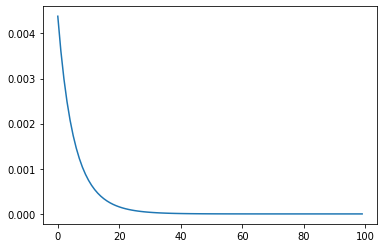

In [ ]:
# Escreva o código aqui

import numpy as np
np.random.seed(1)


class Net():

  def __init__(self, dim=1):
    # Escreva o código aqui: 
    self.w1 = random.random()
    self.w2 = random.random()
    self.b1 = random.random()
    self.b2 = random.random()
    self.Mul = MulLayer()
    self.Sum = SumLayer()
    self.Sig = SigmoidLayer()
    self.mulStack = []

  def forward(self, x):
    # Escreva o código aqui:
    #foward em a
    dot = self.Mul.forward(x,self.w1)
    sum = self.Sum.forward(dot,self.b1)
    a = self.Sig.forward(sum)
    #foward em y
    dot = self.Mul.forward(a,self.w2)
    sum = self.Sum.forward(dot,self.b2)
    y = self.Sig.forward(sum)
    return y
  
  def backward(self, upstream_grad):
    # Escreva o código aqui:
    #backward em y
    dsig = self.Sig.backward(upstream_grad)
    dsum, db2 = self.Sum.backward(dsig)
    da, dw2 = self.Mul.backward(dsum)
    #backward em a
    dsig = self.Sig.backward(da)
    dsum, db1 = self.Sum.backward(dsig)
    dx, dw1 = self.Mul.backward(dsum)

    return dw1 + dw2, db1 + db2


model = Net(dim=1)
learning_rate = 1.0
x = -5
y_target = 0.76
losses = []
for i in range(100):
  y_pred = model.forward(x)
  #Calculo da loss para gráfico
  loss = (y_pred - y_target) ** 2
  losses.append(loss)
  loss_grad = compute_grad_loss(y_target=y_target, y_pred=y_pred)
  w_grad, b_grad = model.backward(loss_grad)
  # Escreva o código aqui para atualizar os pesos:
  model.w1 = model.w1 - learning_rate*w_grad
  model.w2 = model.w2 - learning_rate*w_grad
  model.b1 = model.b1 - learning_rate*w_grad
  model.b2 = model.b2 - learning_rate*b_grad 

  print(f'iter:{i}: y_prime: {y_pred}')
  print(f'model.w1: {model.w1}')
  print(f'model.w2: {model.w2}')

plt.plot(losses)